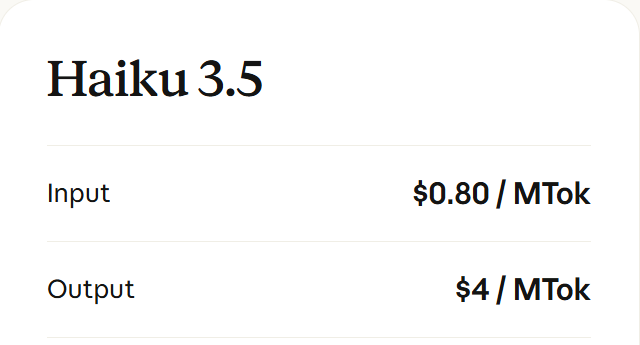

In [1]:
import pandas as pd
from snli_service import get_model_summary, calculate_final_score

In [2]:
gemini_df = pd.read_csv("../natural_language_inference/predictions_train_gemini-2.0-flash.csv")
gpt4o_df = pd.read_csv("../natural_language_inference/predictions_train_gpt-4o.csv")
anthropic_df = pd.read_csv("../natural_language_inference/predictions_train_claude-3-5-haiku.csv")
gpt4o_mini_df = pd.read_csv("../natural_language_inference/predictions_train_gpt-4o-mini.csv")

In [3]:
gemini_df.head(2)

,sentence1,sentence2,gold_label,pred_label,time_sec,prompt_tokens,completion_tokens,total_tokens
0,A kid bored in a train with brown hair and his...,A child is riding the train from New York to B...,neutral,neutral,0.653339,207,2,209
1,A brown dog and black and white dog run along ...,Two squirrels run after acorns in the grass.,contradiction,neutral,0.509239,203,2,205


In [4]:
results_list = []

In [5]:
results_list.append(get_model_summary(gemini_df, "gemini-2.0-flash"))
results_list.append(get_model_summary(gpt4o_df, "gpt-4o"))
results_list.append(get_model_summary(anthropic_df, "claude-3-5-haiku"))
results_list.append(get_model_summary(gpt4o_mini_df, "gpt-4o-mini"))

In [6]:
df_summary = pd.DataFrame(results_list)
display(df_summary.round(4))

,Model,NaN_Count,Total_Support,Accuracy,Support_Cleaned,Total Correct Predictions,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Correct_contradiction,Correct_entailment,Correct_neutral
0,gemini-2.0-flash,0,50,0.6200,50.0,31,0.7556,0.6872,0.6231,0.7707,0.6200,0.5774,5,12,14
1,gpt-4o,0,50,0.7800,50.0,39,0.8225,0.7941,0.7930,0.8227,0.7800,0.7841,14,10,15
2,claude-3-5-haiku,7,50,0.5814,43.0,25,0.7150,0.5966,0.5333,0.7007,0.5814,0.5221,2,12,11
3,gpt-4o-mini,0,50,0.8200,50.0,41,0.8556,0.8177,0.8212,0.8627,0.8200,0.8250,16,9,16


In [7]:
df_summary.to_csv("../natural_language_inference/summary_all_models.csv", index=False)

In [11]:
COST_PER_1_PROMPT = {
    "gpt-4o": 2.50 / 1_000_000,          
    "gpt-4o-mini": 0.15 / 1_000_000,
    "gemini-2.0-flash": 0.1 / 1_000_000, 
    "claude-3-5-haiku": 0.8 / 1_000_000, 
}

COST_PER_1_COMPLETION = {
    "gpt-4o": 10.00 / 1_000_000,         
    "gpt-4o-mini": 0.6 / 1_000_000,
    "gemini-2.0-flash": 0.4 / 1_000_000, 
    "claude-3-5-haiku": 4.0 / 1_000_000, 
}

In [12]:

def calculate_total_cost(df_raw: pd.DataFrame, model_name: str) -> float:
    total_prompt_tokens = df_raw['prompt_tokens'].sum()
    total_completion_tokens = df_raw['completion_tokens'].sum()
    
    cost_p = COST_PER_1_PROMPT.get(model_name, 0)
    cost_c = COST_PER_1_COMPLETION.get(model_name, 0)

    total_cost = (total_prompt_tokens * cost_p) + (total_completion_tokens * cost_c)
    return total_cost


$$\text{Score} = (\text{Weighted F1}) - (\text{Cost Penalty}) - (\text{NaN Penalty})$$

$$\text{Cost Penalty} = \frac{\text{Total Cost}}{\text{Max Total Cost}} \times 0.2$$

$$\text{NaN Penalty} = \frac{\text{Support Lost}}{\text{Total Support}}$$

In [13]:
models_data = [
    (gemini_df, "gemini-2.0-flash"),
    (gpt4o_df, "gpt-4o"),
    (anthropic_df, "claude-3-5-haiku"),
    (gpt4o_mini_df, "gpt-4o-mini")
]

In [16]:
results_list = []
for df_curr, name in models_data:
    summary_series = get_model_summary(df_curr, name)
    summary_dict = summary_series.to_dict()
    summary_dict['Total_Cost'] = calculate_total_cost(df_curr, name)
    
    results_list.append(summary_dict)

df_summary = pd.DataFrame(results_list)

final_results = calculate_final_score(df_summary)

,Model,Weighted F1,Total_Cost,NaN_Count,Cost_Penalty,NaN_Penalty,Final_Score
3,gpt-4o-mini,0.8250,0.0016,0,0.0120,0.00,0.8130
1,gpt-4o,0.7841,0.0268,0,0.1994,0.00,0.5847
0,gemini-2.0-flash,0.5774,0.0011,0,0.0080,0.00,0.5694
2,claude-3-5-haiku,0.5221,0.0269,7,0.2000,0.14,0.1821



Best model: gpt-4o-mini


In [17]:
final_results.to_csv("../natural_language_inference/summary_all_models_with_costs.csv", index=False)